## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm, trange

import eq
from eq.models import RecurrentTPP
from eq.catalogs.Combined_Catalog import CombinedCatalog

from eq.data import Catalog, InMemoryDataset, Sequence, default_catalogs_dir

In [2]:
device="cuda"

In [9]:
raise Exception("unpickle it!")
np.random.seed(42)
test_catalog = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=20000,
    radius_kilometers = 200,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,
)

assert [len(seq.inter_times) for seq in test_catalog.test][:10] == [44, 22, 16, 54, 84, 8, 8, 201, 383, 30]
with open("test_catalog", "wb") as f:
    pickle.dump(test_catalog, f)

test_dl = test_catalog.test.get_dataloader()
with open("test_dl", "wb") as f:
    pickle.dump(test_dl, f)

Exception: unpickle it!

In [3]:
with open("test_dl", "rb") as f:
    test_dl = pickle.load(f)

In [4]:
def train(model, optimizer, dl_train, dl_val, epochs, best_model_path):
    avg_train_loss_list = []
    avg_val_loss_list = []
    best_val_loss = float('inf')
    for epoch in trange(epochs):
        running_train_loss = []
        model.train()
        for i, data in enumerate(dl_train):
            data = data.to(device)
            optimizer.zero_grad()
            nll = model.nll_loss(data).mean()
            nll.backward()
            optimizer.step()
            running_train_loss.append(nll.item())
                    
        model.eval()
        with torch.no_grad():
            running_val_loss = []
            for i, data in enumerate(dl_val):
                data = data.to(device)
                nll = model.nll_loss(data).mean()
                running_val_loss.append(nll.item())

        avg_val_loss = np.mean(running_val_loss)
        avg_train_loss = np.mean(running_train_loss)
        avg_train_loss_list.append(avg_train_loss)
        avg_val_loss_list.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
    model.load_state_dict(torch.load(best_model_path))
    return model, avg_train_loss_list, avg_val_loss_list

def test(model, dl_test):
    model.eval()
    with torch.no_grad():
        nll_loss_list = []
        for i, data in enumerate(dl_test):
            data = data.to(device)
            nll = model.nll_loss(data).mean()
            nll_loss_list.append(nll.item())
        print("avg nll loss: ", np.mean(nll_loss_list))
    return np.mean(nll_loss_list)

In [5]:
catalogs = []
anss = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=100,
    t_end_days=1*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,
    include_depth=False
)
catalogs.append(anss)
scedc = eq.catalogs.SCEDC(include_depth=False)
catalogs.append(scedc)
white = eq.catalogs.White()
catalogs.append(white)

Loading existing catalog from /home/zekai/repos/recast/data/ANSS_MultiCatalog.
Loading existing catalog from /home/zekai/repos/recast/data/SCEDC.
Loading existing catalog from /home/zekai/repos/recast/data/White.


/home/zekai/repos/recast/eq/data/sequence.py:213: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


## Sanity Check: train on the common test catalog

In [6]:
with open("test_catalog", "rb") as f:
    test_catalog = pickle.load(f)

batch_size = 32
test_catalog_train_dl = test_catalog.train.get_dataloader(batch_size=batch_size)
test_catalog_val_dl = test_catalog.val.get_dataloader(batch_size=batch_size)

T = test_catalog.train.sequences[0].t_end
N = np.mean([len(seq) for seq in test_catalog.train.sequences])
tau_mean = T/N

model = RecurrentTPP(
    context_size=32,
    num_components=32,
    rnn_type="LSTM",
    dropout_proba=0.1,
    tau_mean=tau_mean,
    learning_rate=0.005
)

model = model.to(device)

optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.005, 
        betas=(0.99, 0.999), 
        weight_decay=0.005
    )

epochs = 50

In [7]:
model, avg_train_loss_list, avg_val_loss_list = train(
    model=model, 
    optimizer=optimizer, 
    dl_train=test_catalog_train_dl, 
    dl_val=test_catalog_val_dl,
    epochs=epochs,
    best_model_path="temp"
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [32, 1], which does not match the required output shape [32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/Resize.cpp:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [32, 783, 1], which does not match the required output shape [32, 783, 32]. This behavior is deprecated, and in a future P

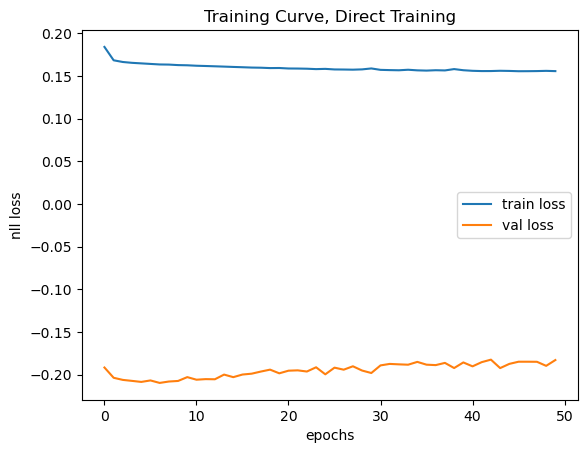

In [8]:
plt.plot(np.arange(epochs), avg_train_loss_list, label="train loss")
plt.plot(np.arange(epochs), avg_val_loss_list, label="val loss")
plt.xlabel("epochs")
plt.ylabel("nll loss")
plt.title("Training Curve, Direct Training")
plt.legend()
plt.show()

In [9]:
avg_test_loss = test(model=model, dl_test=test_dl)

avg nll loss:  0.15901731122705678


In [24]:
model.load_state_dict(torch.load("temp"))
test(model=model, dl_test=white.test.get_dataloader())

avg nll loss:  -85.99324274416323


-85.99324274416323

In [25]:
model.load_state_dict(torch.load("temp"))
test(model=model, dl_test=scedc.test.get_dataloader())

avg nll loss:  -405.20597926409


-405.20597926409

## Direct Training

In [6]:
batch_size = 32
anss_train_dl = anss.train.get_dataloader(batch_size=batch_size)
anss_val_dl = anss.val.get_dataloader(batch_size=batch_size)

T = anss.train.sequences[0].t_end
N = np.mean([len(seq) for seq in anss.train.sequences])
tau_mean = T/N

model = RecurrentTPP(
    context_size=32,
    num_components=32,
    rnn_type="LSTM",
    dropout_proba=0.1,
    tau_mean=tau_mean,
    learning_rate=0.005
)

model = model.to(device)

optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.005, 
        betas=(0.99, 0.999), 
        weight_decay=0.005
    )

epochs = 200
best_model_path = "direct_training_best_model"

In [14]:
model, avg_train_loss_list, avg_val_loss_list = train(
    model=model, 
    optimizer=optimizer, 
    dl_train=anss_train_dl, 
    dl_val=anss_val_dl,
    epochs=epochs,
    best_model_path=best_model_path
)

  0%|          | 0/200 [00:00<?, ?it/s]/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [32, 406, 1], which does not match the required output shape [32, 406, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/Resize.cpp:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [28, 1], which does not match the required output shape [28, 32]. This behavior is deprecated, and in a future 

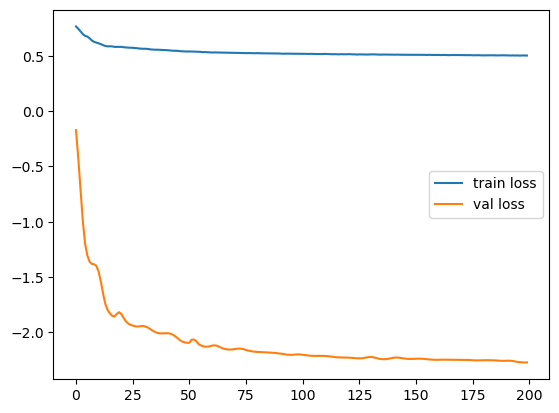

In [15]:
plt.plot(np.arange(epochs), avg_train_loss_list, label="train loss")
plt.plot(np.arange(epochs), avg_val_loss_list, label="val loss")
plt.legend()
plt.show()

In [16]:
avg_test_loss = test(model=model, dl_test=test_dl)

avg nll loss:  0.1725792881622192


## Pretrain

In [6]:
# pretrain on mixture dataset, 0.34 0.33 0.33 ratio
batch_size = 32
combined_catalog = CombinedCatalog(catalogs, [0.34, 0.33, 0.33])
conbined_train_dl = combined_catalog.combined_info["combined_train"].get_dataloader(batch_size=batch_size)
combined_val_dl = combined_catalog.combined_info["combined_val"].get_dataloader(batch_size=batch_size)

T = combined_catalog.combined_info['combined_train'].sequences[0].t_end
N = np.mean([len(seq) for seq in combined_catalog.combined_info['combined_train'].sequences])
tau_mean = T/N

model = RecurrentTPP(
    context_size=32,
    num_components=32,
    rnn_type="LSTM",
    dropout_proba=0.1,
    tau_mean=tau_mean,
    learning_rate=0.005
)

model = model.to(device)

optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.005, 
        betas=(0.99, 0.999), 
        weight_decay=0.005
    )

epochs = 200
best_model_path = "pretrain_best_model"

Loading existing catalog from /home/zekai/repos/recast/notebooks/Zekai/combined.
203
69.0
60
67.0
67
67.0
53


/home/zekai/repos/recast/eq/data/sequence.py:213: UserWarning: Found 2 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


In [7]:
model, avg_train_loss_list, avg_val_loss_list = train(
    model=model, 
    optimizer=optimizer, 
    dl_train=conbined_train_dl, 
    dl_val=combined_val_dl,
    epochs=epochs,
    best_model_path=best_model_path
)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [32, 1], which does not match the required output shape [32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/Resize.cpp:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: An output with one or more elements was resized since it had shape [32, 406, 1], which does not match the required output shape [32, 406, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be res

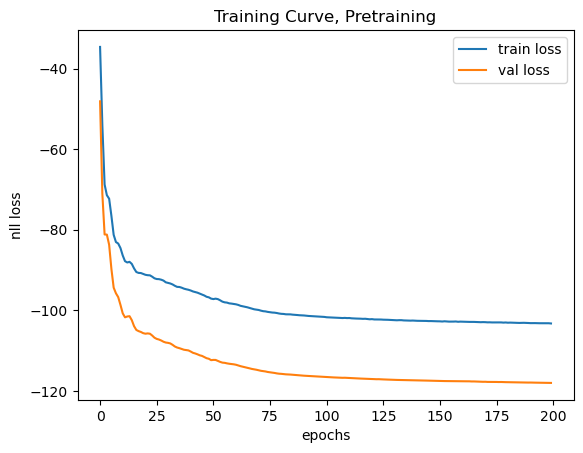

In [8]:
plt.plot(np.arange(epochs), avg_train_loss_list, label="train loss")
plt.plot(np.arange(epochs), avg_val_loss_list, label="val loss")
plt.xlabel("epochs")
plt.ylabel("nll loss")
plt.title("Training Curve, Pretraining")
plt.legend()
plt.show()

In [9]:
avg_test_loss = test(model=model, dl_test=test_dl)

avg nll loss:  0.2286933710812882


In [19]:
model.load_state_dict(torch.load("pretrain_best_model"))
test(model=model, dl_test=white.test.get_dataloader())

avg nll loss:  -88.21128205193413


-88.21128205193413

In [20]:
avg nll loss:  0.2286933710812882


avg nll loss:  -408.11922875777003


-408.11922875777003

## Finetune

In [14]:
batch_size = 32
with open("test_catalog", "rb") as f:
    test_catalog = pickle.load(f)
common_train_dl = test_catalog.train.get_dataloader(batch_size=batch_size)
common_val_dl = test_catalog.val.get_dataloader(batch_size=batch_size)

T = test_catalog.train.sequences[0].t_end
N = np.mean([len(seq) for seq in test_catalog.train.sequences])
tau_mean = T/N

model = RecurrentTPP(
    context_size=32,
    num_components=32,
    rnn_type="LSTM",
    dropout_proba=0.1,
    tau_mean=tau_mean,
    learning_rate=0.005
)
model.to(device)
model.load_state_dict(torch.load("pretrain_best_model"))
model.tau_mean = torch.tensor(tau_mean)

optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.005, 
        betas=(0.99, 0.999), 
        weight_decay=0.005
    )

epochs = 50
best_model_path = "finetune_best_model"

In [15]:
model, avg_train_loss_list, avg_val_loss_list = train(
    model=model, 
    optimizer=optimizer, 
    dl_train=common_train_dl, 
    dl_val=common_val_dl,
    epochs=epochs,
    best_model_path=best_model_path
)

100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


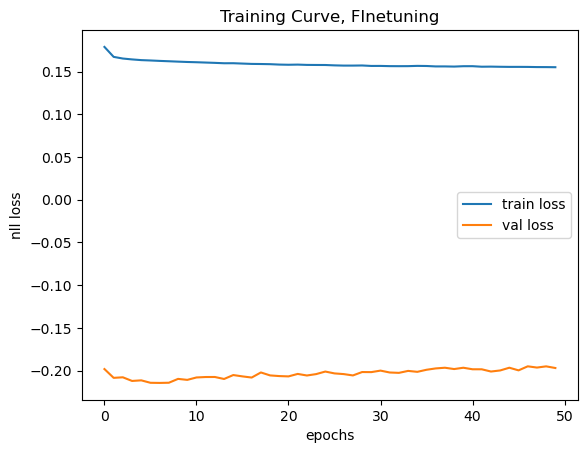

In [18]:
plt.plot(np.arange(epochs), avg_train_loss_list, label="train loss")
plt.plot(np.arange(epochs), avg_val_loss_list, label="val loss")
plt.xlabel("epochs")
plt.ylabel("nll loss")
plt.title("Training Curve, FInetuning")
plt.legend()
plt.show()

In [17]:
avg_test_loss = test(model=model, dl_test=test_dl)

avg nll loss:  0.15917552852253355


In [21]:
model.load_state_dict(torch.load("finetune_best_model"))
test(model=model, dl_test=white.test.get_dataloader())

avg nll loss:  -86.33689513736302


-86.33689513736302

In [23]:
model.load_state_dict(torch.load("finetune_best_model"))
test(model=model, dl_test=scedc.test.get_dataloader())

avg nll loss:  -408.2804798877665


-408.2804798877665